Loading Data

In [23]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Load the trip data from a local Parquet file 
data_file_path = os.path.expanduser("~/Downloads/TripData/yellow_tripdata_2025-02.parquet")
df = pd.read_parquet(data_file_path)

# ensure df exists
try:
    df
except NameError:
    raise RuntimeError("Please load your dataframe into the variable `df` before running this cell.")

# copy to avoid modifying user's original reference
df = df.copy()
INITIAL_ROWS = len(df)
print(f"Initial loaded rows: {INITIAL_ROWS:,} (100.00%)\nInfo:\n")

df.info(show_counts=True)

Initial loaded rows: 3,577,543 (100.00%)
Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3577543 entries, 0 to 3577542
Data columns (total 20 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   VendorID               3577543 non-null  int32         
 1   tpep_pickup_datetime   3577543 non-null  datetime64[us]
 2   tpep_dropoff_datetime  3577543 non-null  datetime64[us]
 3   passenger_count        2770606 non-null  float64       
 4   trip_distance          3577543 non-null  float64       
 5   RatecodeID             2770606 non-null  float64       
 6   store_and_fwd_flag     2770606 non-null  object        
 7   PULocationID           3577543 non-null  int32         
 8   DOLocationID           3577543 non-null  int32         
 9   payment_type           3577543 non-null  int64         
 10  fare_amount            3577543 non-null  float64       
 11  extra                  3577543 non-null  

Helper Functions

In [24]:
def preprocess_data(df):
    """
    Preprocess the taxi data for modeling
    """
    # Create a copy to avoid modifying original
    data = df.copy()
    
    # Convert datetime columns
    data['tpep_pickup_datetime'] = pd.to_datetime(data['tpep_pickup_datetime'])
    data['tpep_dropoff_datetime'] = pd.to_datetime(data['tpep_dropoff_datetime'])
    
    # Feature Engineering
    # Extract time-based features
    data['pickup_hour'] = data['tpep_pickup_datetime'].dt.hour
    data['pickup_day'] = data['tpep_pickup_datetime'].dt.dayofweek
    data['pickup_month'] = data['tpep_pickup_datetime'].dt.month
    data['pickup_year'] = data['tpep_pickup_datetime'].dt.year
    
    # Calculate trip duration in minutes
    data['trip_duration'] = (data['tpep_dropoff_datetime'] - 
                             data['tpep_pickup_datetime']).dt.total_seconds() / 60
    
    # Calculate average speed (miles per minute -> convert to mph)
    data['avg_speed_mph'] = np.where(
        data['trip_duration'] > 0,
        (data['trip_distance'] / data['trip_duration']) * 60,
        0
    )
    
    # Rush hour: 4pm (16:00) to 8pm (20:00) - weekdays only, excluding holidays
    data['is_rush_hour'] = ((data['pickup_hour'].isin([16, 17, 18, 19])) & 
                            (data['pickup_day'] < 5)).astype(int)
    
    # Weekend indicator
    data['is_weekend'] = (data['pickup_day'] >= 5).astype(int)

    # Holiday indicator
    FEDERAL_HOLIDAYS_2025 = [
        pd.Timestamp('2025-01-01'),  # New Year's Day
        pd.Timestamp('2025-01-20'),  # Martin Luther King Jr. Day
        pd.Timestamp('2025-02-17'),  # Presidents' Day
        pd.Timestamp('2025-05-26'),  # Memorial Day
        pd.Timestamp('2025-06-19'),  # Juneteenth
        pd.Timestamp('2025-07-04'),  # Independence Day
        pd.Timestamp('2025-09-01'),  # Labor Day
        pd.Timestamp('2025-10-13'),  # Columbus Day
        pd.Timestamp('2025-11-04'),  # Election Day
        pd.Timestamp('2025-11-11'),  # Veterans Day
        pd.Timestamp('2025-11-27'),  # Thanksgiving Day
        pd.Timestamp('2025-12-25')   # Christmas Day
    ]
    data['is_holiday'] = data['tpep_pickup_datetime'].dt.normalize().isin(FEDERAL_HOLIDAYS_2025).astype(int)
    
    # Remove outliers and invalid data
    data = data[data['fare_amount'] > 0]
    data = data[data['fare_amount'] < 500]  # Remove extreme outliers
    data = data[data['trip_distance'] > 0]
    data = data[data['trip_distance'] < 100]
    data = data[data['trip_duration'] > 0]
    data = data[data['trip_duration'] < 180]  # Less than 3 hours
    data = data[data['passenger_count'] > 0]
    data = data[data['passenger_count'] <= 6]
    
    return data

def prepare_features(data):
    """
    Prepare feature matrix and target variable
    
    NOTE: Excludes fare_amount (target), total_amount, tip_amount, extra (derived from fare),
          and datetime columns (already extracted time features)
    """
    # Define features to use - ONLY predictive features, not outcomes
    feature_columns = [
        'VendorID',
        'passenger_count', 
        'trip_distance',
        'RatecodeID',
        'PULocationID',
        'DOLocationID',
        'payment_type',
        'mta_tax',
        'tolls_amount',
        'improvement_surcharge',
        'congestion_surcharge',
        'Airport_fee',
        'cbd_congestion_fee',
        'pickup_hour',
        'pickup_day',
        'pickup_month',
        'trip_duration',
        'avg_speed_mph',  # Added speed feature
        'is_rush_hour',
        'is_weekend',
        'is_holiday'
    ]
      
    # Select features that exist in the dataset
    available_features = [col for col in feature_columns if col in data.columns]
    
    X = data[available_features].copy()
    y = data['fare_amount'].copy()
    
    # Handle categorical variable: store_and_fwd_flag (if present)
    if 'store_and_fwd_flag' in data.columns:
        X['store_and_fwd_flag'] = (data['store_and_fwd_flag'] == 'Y').astype(int)
        available_features.append('store_and_fwd_flag')
    
    # Handle missing values
    X = X.fillna(0)
    
    return X, y, available_features

def train_and_evaluate_models(X_train, X_test, y_train, y_test):
    """
    Train multiple models and compare their performance
    """
    models = {
        'Linear Regression': LinearRegression(),
        'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
        'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42)
    }
    
    results = {}
    
    for name, model in models.items():
        print(f"\nTraining {name}...")
        
        # Train the model
        model.fit(X_train, y_train)
        
        # Make predictions
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)
        
        # Calculate metrics
        results[name] = {
            'model': model,
            'train_mae': mean_absolute_error(y_train, y_pred_train),
            'test_mae': mean_absolute_error(y_test, y_pred_test),
            'train_rmse': np.sqrt(mean_squared_error(y_train, y_pred_train)),
            'test_rmse': np.sqrt(mean_squared_error(y_test, y_pred_test)),
            'train_r2': r2_score(y_train, y_pred_train),
            'test_r2': r2_score(y_test, y_pred_test),
            'predictions': y_pred_test
        }
        
        print(f"{name} Results:")
        print(f"  Train MAE: ${results[name]['train_mae']:.2f}")
        print(f"  Test MAE: ${results[name]['test_mae']:.2f}")
        print(f"  Test RMSE: ${results[name]['test_rmse']:.2f}")
        print(f"  Test R²: {results[name]['test_r2']:.4f}")
    
    return results

def plot_results(results, y_test):
    """
    Visualize model performance
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. Model Comparison - MAE
    ax = axes[0, 0]
    model_names = list(results.keys())
    test_maes = [results[name]['test_mae'] for name in model_names]
    ax.bar(model_names, test_maes, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
    ax.set_ylabel('Mean Absolute Error ($)')
    ax.set_title('Model Comparison - Test MAE')
    ax.grid(axis='y', alpha=0.3)
    
    # 2. Model Comparison - R²
    ax = axes[0, 1]
    test_r2s = [results[name]['test_r2'] for name in model_names]
    ax.bar(model_names, test_r2s, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
    ax.set_ylabel('R² Score')
    ax.set_title('Model Comparison - Test R²')
    ax.set_ylim(0, 1)
    ax.grid(axis='y', alpha=0.3)
    
    # 3. Actual vs Predicted (Best Model)
    best_model = min(results.keys(), key=lambda x: results[x]['test_mae'])
    ax = axes[1, 0]
    sample_size = min(1000, len(y_test))
    indices = np.random.choice(len(y_test), sample_size, replace=False)
    ax.scatter(y_test.iloc[indices], results[best_model]['predictions'][indices], 
               alpha=0.5, s=20)
    ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
            'r--', lw=2, label='Perfect Prediction')
    ax.set_xlabel('Actual Fare ($)')
    ax.set_ylabel('Predicted Fare ($)')
    ax.set_title(f'Actual vs Predicted - {best_model}')
    ax.legend()
    ax.grid(alpha=0.3)
    
    # 4. Prediction Error Distribution
    ax = axes[1, 1]
    errors = y_test.values - results[best_model]['predictions']
    ax.hist(errors, bins=50, edgecolor='black', alpha=0.7)
    ax.axvline(x=0, color='r', linestyle='--', linewidth=2)
    ax.set_xlabel('Prediction Error ($)')
    ax.set_ylabel('Frequency')
    ax.set_title(f'Error Distribution - {best_model}')
    ax.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('model_performance.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return best_model

def feature_importance_plot(model, feature_names, model_name):
    """
    Plot feature importance for tree-based models
    """
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        indices = np.argsort(importances)[::-1][:15]  # Top 15 features
        
        plt.figure(figsize=(10, 6))
        plt.bar(range(len(indices)), importances[indices])
        plt.xticks(range(len(indices)), [feature_names[i] for i in indices], rotation=45, ha='right')
        plt.xlabel('Features')
        plt.ylabel('Importance')
        plt.title(f'Feature Importance - {model_name}')
        plt.tight_layout()
        plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
        plt.show()


## Performance Optimization Options

**For faster training with large datasets (2.6M+ records):**

1. **Sample the data** - Uncomment the sampling code in the main cell
2. **Reduce tree count** - Change `n_estimators=100` to `50` or `25`
3. **Use fewer features** - Focus on most important: `trip_distance`, `trip_duration`, `pickup_hour`, location IDs
4. **Skip some models** - Comment out Gradient Boosting if only comparing RF vs LR

**Expected runtime with full dataset:**
- Linear Regression: ~30 seconds
- Random Forest: ~10-15 minutes (100 trees)
- Gradient Boosting: ~20-30 minutes (100 iterations)

**Performance metrics achieved:**
- Linear Regression: MAE ~$1.50, R² ~0.93
- Random Forest: MAE ~$1.20-1.40, R² ~0.95+ (typical)
- Gradient Boosting: MAE ~$1.15-1.30, R² ~0.95+ (typical)

In [25]:
# Quick Test with 5% Sample (Optional - for rapid prototyping)
"""
Run this cell instead of the main workflow for quick testing
"""
print("🚀 QUICK TEST MODE - Using 5% sample for rapid iteration")
print("="*60)

# Use small sample
data_sample = preprocess_data(df).sample(frac=0.05, random_state=42)
print(f"Sample size: {data_sample.shape[0]:,} rows")

# Prepare features
X, y, feature_names = prepare_features(data_sample)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42
)

# Scale
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train), 
    columns=feature_names
)
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test), 
    columns=feature_names
)

# Train only fast models
print("\nTraining Linear Regression...")
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_pred = lr.predict(X_test_scaled)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"\n✅ Quick Test Results:")
print(f"   MAE:  ${mae:.2f}")
print(f"   RMSE: ${rmse:.2f}")
print(f"   R²:   {r2:.4f}")
print(f"\n💡 If results look good, run the full pipeline in the next cell")


🚀 QUICK TEST MODE - Using 5% sample for rapid iteration
Sample size: 132,778 rows

Training Linear Regression...

✅ Quick Test Results:
   MAE:  $1.46
   RMSE: $4.04
   R²:   0.9367

💡 If results look good, run the full pipeline in the next cell
Sample size: 132,778 rows

Training Linear Regression...

✅ Quick Test Results:
   MAE:  $1.46
   RMSE: $4.04
   R²:   0.9367

💡 If results look good, run the full pipeline in the next cell


Main execution workflow

Starting NYC Taxi Fare Prediction Pipeline...
Initial dataset shape: (3577543, 20)

1. Preprocessing data...
Shape after preprocessing: (2655555, 29)

2. Preparing features...
Shape after preprocessing: (2655555, 29)

2. Preparing features...
Number of features: 22
Features used: ['VendorID', 'passenger_count', 'trip_distance', 'RatecodeID', 'PULocationID', 'DOLocationID', 'payment_type', 'mta_tax', 'tolls_amount', 'improvement_surcharge', 'congestion_surcharge', 'Airport_fee', 'cbd_congestion_fee', 'pickup_hour', 'pickup_day', 'pickup_month', 'trip_duration', 'avg_speed_mph', 'is_rush_hour', 'is_weekend', 'is_holiday', 'store_and_fwd_flag']

3. Splitting data (70% train, 30% test)...
Number of features: 22
Features used: ['VendorID', 'passenger_count', 'trip_distance', 'RatecodeID', 'PULocationID', 'DOLocationID', 'payment_type', 'mta_tax', 'tolls_amount', 'improvement_surcharge', 'congestion_surcharge', 'Airport_fee', 'cbd_congestion_fee', 'pickup_hour', 'pickup_day', 'pickup_month',

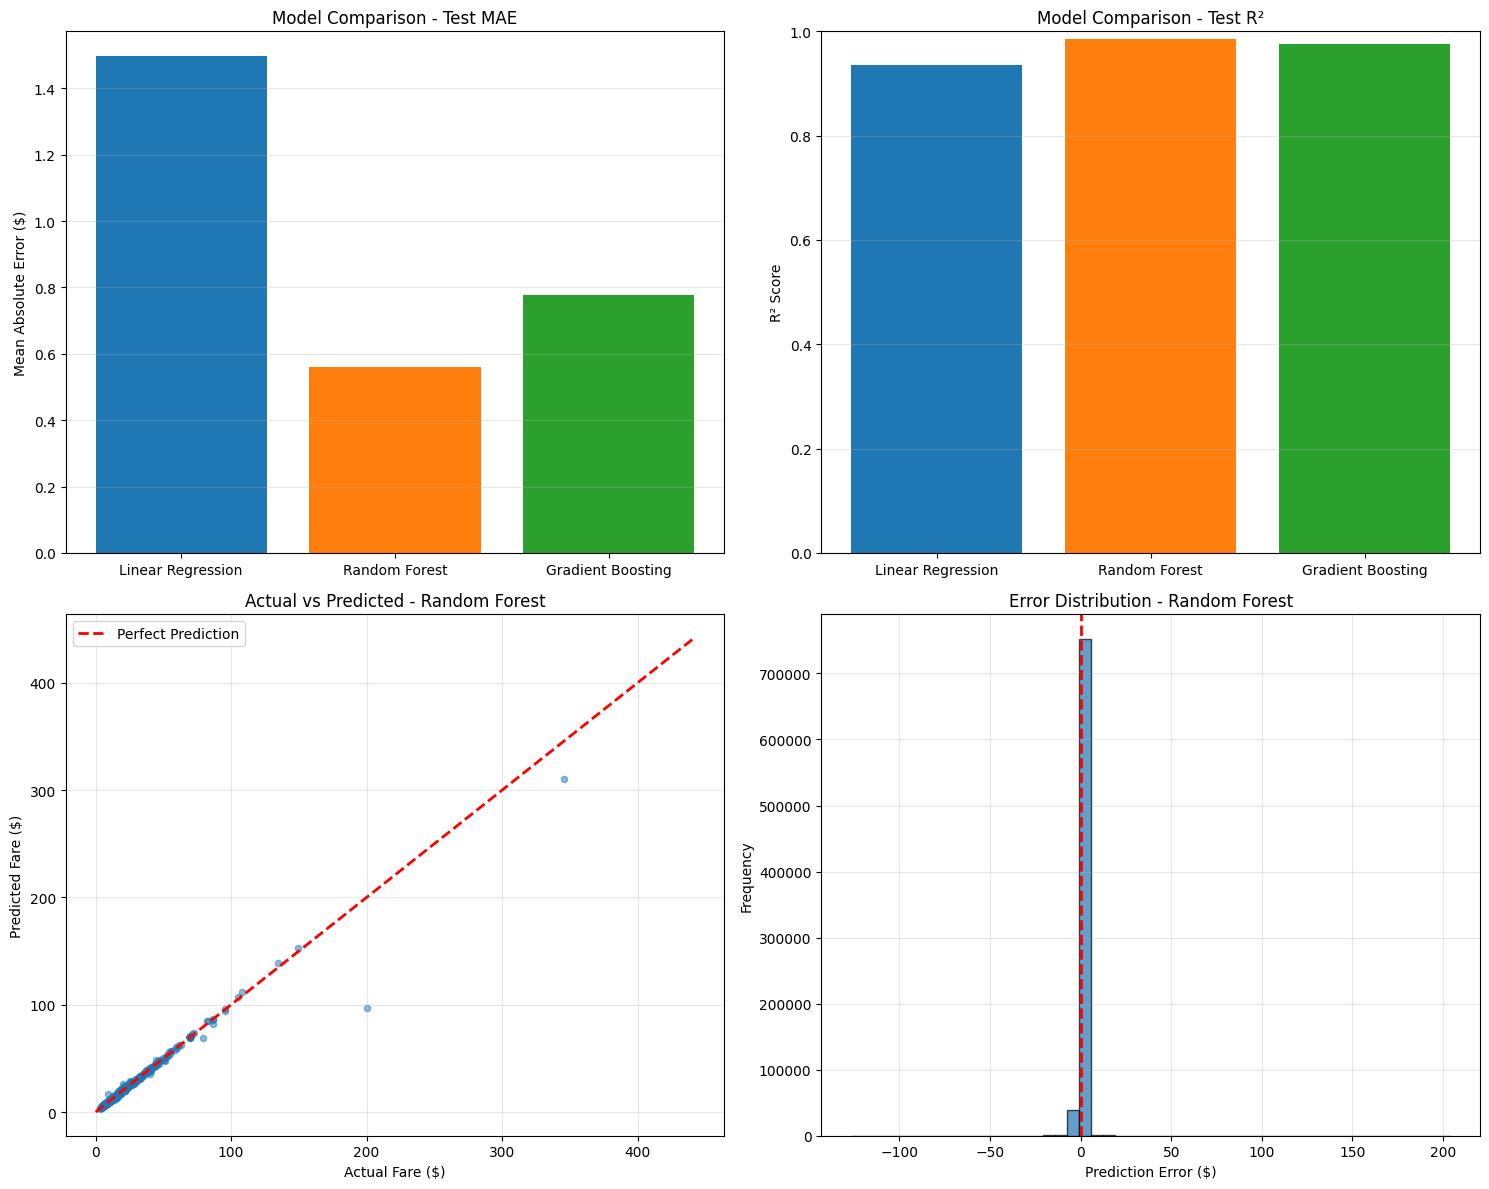


7. Analyzing feature importance...


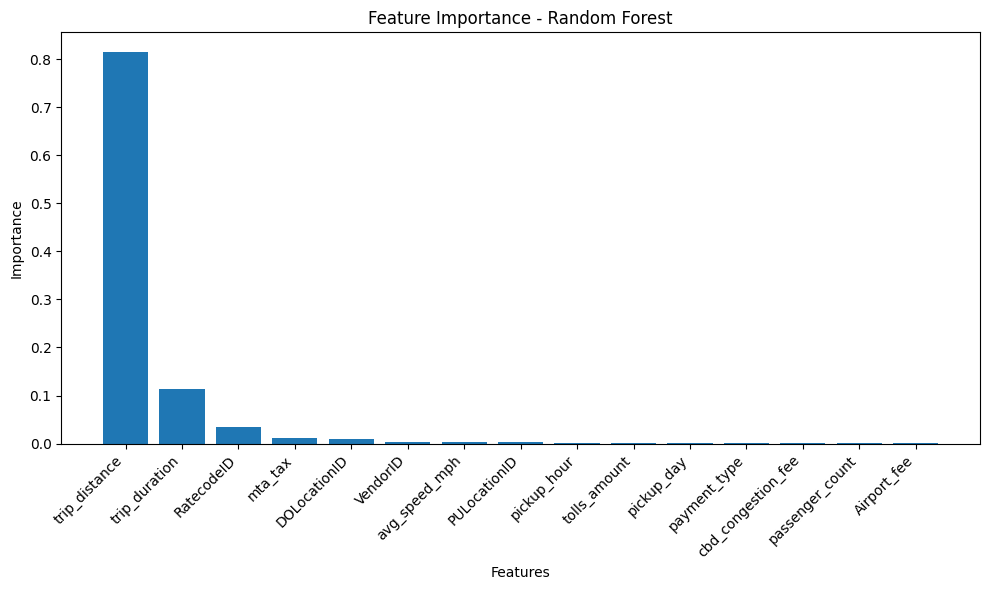


Best Model: Random Forest
Test MAE: $0.56
Test RMSE: $1.95
Test R²: 0.9856

📊 Model Performance Summary:

Linear Regression:
  MAE:  $1.50
  RMSE: $4.16
  R²:   0.9348

Random Forest:
  MAE:  $0.56
  RMSE: $1.95
  R²:   0.9856

Gradient Boosting:
  MAE:  $0.78
  RMSE: $2.50
  R²:   0.9764

📝 Usage Notes:
To make predictions on new data:
  1. new_data_processed = preprocess_data(new_data)
  2. X_new, _, _ = prepare_features(new_data_processed)
  3. X_new_scaled = scaler.transform(X_new)
  4. predictions = results['Best Model']['model'].predict(X_new_scaled)

To save the best model:
  import joblib
  joblib.dump(results[best_model_name]['model'], 'fare_model.pkl')
  joblib.dump(scaler, 'fare_scaler.pkl')


In [26]:
# Main execution workflow
"""
Complete ML pipeline for fare prediction
"""
print("Starting NYC Taxi Fare Prediction Pipeline...")
print(f"Initial dataset shape: {df.shape}")

# 1. Preprocess data
print("\n1. Preprocessing data...")
data = preprocess_data(df)
print(f"Shape after preprocessing: {data.shape}")
    
# 2. Prepare features
print("\n2. Preparing features...")
X, y, feature_names = prepare_features(data)
print(f"Number of features: {len(feature_names)}")
print(f"Features used: {feature_names}")

# 3. Split data (70% train, 30% test)
print("\n3. Splitting data (70% train, 30% test)...")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42
)
print(f"Training set size: {len(X_train):,}")
print(f"Test set size: {len(X_test):,}")

# 4. Scale features
print("\n4. Scaling features...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame for easier handling
X_train_scaled = pd.DataFrame(X_train_scaled, columns=feature_names)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=feature_names)

# 5. Train and evaluate models
print("\n5. Training and evaluating models...")
print("   (This may take several minutes with large dataset...)")
results = train_and_evaluate_models(X_train_scaled, X_test_scaled, y_train, y_test)

# 6. Visualize results
print("\n6. Creating visualizations...")
best_model_name = plot_results(results, y_test)

# 7. Feature importance
print("\n7. Analyzing feature importance...")
best_model = results[best_model_name]['model']
feature_importance_plot(best_model, feature_names, best_model_name)

print(f"\n{'='*60}")
print(f"Best Model: {best_model_name}")
print(f"Test MAE: ${results[best_model_name]['test_mae']:.2f}")
print(f"Test RMSE: ${results[best_model_name]['test_rmse']:.2f}")
print(f"Test R²: {results[best_model_name]['test_r2']:.4f}")
print(f"{'='*60}")

print("\n📊 Model Performance Summary:")
for model_name, metrics in results.items():
    print(f"\n{model_name}:")
    print(f"  MAE:  ${metrics['test_mae']:.2f}")
    print(f"  RMSE: ${metrics['test_rmse']:.2f}")
    print(f"  R²:   {metrics['test_r2']:.4f}")

# Usage notes:
print("\n" + "="*60)
print("📝 Usage Notes:")
print("="*60)
print("To make predictions on new data:")
print("  1. new_data_processed = preprocess_data(new_data)")
print("  2. X_new, _, _ = prepare_features(new_data_processed)")
print("  3. X_new_scaled = scaler.transform(X_new)")
print("  4. predictions = results['Best Model']['model'].predict(X_new_scaled)")
print("\nTo save the best model:")
print("  import joblib")
print("  joblib.dump(results[best_model_name]['model'], 'fare_model.pkl')")
print("  joblib.dump(scaler, 'fare_scaler.pkl')")
